# Predicting US Stocks Returns Direction (UP/DOWN)
## Implementing Anchor bias theory 


### Problem Identification :
Investors are anchored to the long term moving averages. The long term moving average is defined by the 252 moving average, and the short term is defined by the 21-Day moving average. The distance between the two moving averages is the moving average distance (MAD = 21-DAY MA / 252-DAY MA). When the MAD>1, the ditance is called a positive spread and when MAD< 1, the distance is caleed a negative spread. 

The ancnchor bias theory, published in a research paper by Avramov, Kaplanski, Subrahmanyam(2018), states that when MAD spread is positive positive announcment (sentiment) drive the price of the stocks to go up more than than negative sentiment drive the price to go down. However, when MAD spread is negative, negative sentiment drives price to go down more than positive sentiment drives re price to go up. Noting that the larger/ smaller the MAD, in both cases, the more effective is the strategy

The model proposed is to predict US stocks returns ( +/-) based on several features but mainly on a BUY or SELL signal. The engineered feature, named trading signal is the main feature which is processed by the constructed pipeline. The BUY signal is construcetd by getting positive sentiment from 2 databases (Sentdex and stocktwits), a 7 days previous senitiment score and a positive MAD greater than 1.2. The SELL signal is set based on negative sentiment scores from 2 databases, also a 7 day previous negative score and a negative MAD less than 0.8.

The stated signals are passed to the pipeline to pass through more than 8000 US stocks and filter out each day, the stocks that passed the criteria. Several screens where passed to the timeline to insure no stock has a null sentiment score (in any of the two databases) or a zero return ( which was actually found).Several other features where passed to the pipeline to output a dataframe of the filtered stocks. After doing the nessary transformations, the data is based to two machine learing algorithms.

## Data Gathering using a Pipeline:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [1]:
# Import Pipeline class and datasets
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits
# from quantopian.interactive.data.sentdex import sentiment
from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.factors import CustomFactor, MarketCap, Latest
from quantopian.pipeline.classifiers.fundamentals import SuperSector
# Import built-in moving average calculation
from quantopian.pipeline.factors import SimpleMovingAverage, DailyReturns, Returns

# Import built-in trading universe
from quantopian.pipeline.experimental import QTradableStocksUS

# Define our own custom factor class
class SentimentSevenDaysAgo(CustomFactor):
    inputs = [sentiment.sentiment_signal]
    window_length=7

    def compute(self, today, assets, out, sentiment):
        out[:] = sentiment[0] #When I specified a window _length of 7 it gave back last 7 scores thus call the senitment Boundcolumn from the top index


def make_pipeline():
    # Create a reference to our trading universe
    base_universe = QTradableStocksUS()

    # Get latest closing price
    close_price = USEquityPricing.close.latest
    
    daily_returns = DailyReturns(
        inputs = [USEquityPricing.close])
    
    returns_3 = Returns(
        inputs = [USEquityPricing.close],
        window_length = 2)
    
    
    mean_close_21 = SimpleMovingAverage(
        inputs = [USEquityPricing.close],
        window_length= 21)
    
    mean_close_252 = SimpleMovingAverage(
        inputs = [USEquityPricing.close],
        window_length= 252)    
    
    MAD = mean_close_21 / mean_close_252
    
    sentdex_score = sentiment.sentiment_signal.latest
    
    sentdex_lag = SentimentSevenDaysAgo()
     
    marketCap = MarketCap()
    
    stock_class = SuperSector()
    
    not_zero_returns = (daily_returns != 0) & (returns_3 !=0)
    # Calculate 3 day average of bull_minus_bear scores
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=2,
    )
    # Create filter for positive/negative spread moving averages
    # Create filter for positive sentiment scores
    # Crate filter for 7 days lag sentiment score
    # assets based on their sentiment scores
    positive_MAD = MAD > 1.2
    negative_MAD = MAD < 0.8
    
    positive_sentiment_lag = sentdex_lag > 3
    negative_sentiment_lag = sentdex_lag < -1
    
    positive_sentiment = sentdex_score > 2
    negative_sentiment = sentdex_score < -1
    
    positive_twits = sentiment_score > 0
    negative_twits = sentiment_score < 0
#     Long = sentdex_lag.top(10, mask = positive_MAD)
#     short = sentdex_lag.bottom(10, mask = negative_MAD) 

    
    

    Long = (positive_MAD & positive_sentiment_lag & positive_twits & positive_sentiment)
    short = (negative_MAD & negative_sentiment_lag & negative_twits )
    
    tradeable_equities = (Long | short)
    # Return Pipeline containing all below columns and
    # sentiment_score that has our trading universe as screen
    return Pipeline(
        columns={
            'close_price': close_price,
            "Sentdex": sentdex_score,
            "Sentdex_lag": sentdex_lag,
            'sentiment_score': sentiment_score.zscore(), #apply zscore to normalize
            "MAD": MAD,
            "BUY": Long,
            "SHORT": short,
            "return": daily_returns,
            "Returns": returns_3,
            "Market Capital.": marketCap,
            "Stock Classfiaction": stock_class
        },
        screen=(base_universe
        & tradeable_equities& sentdex_lag.notnull() & sentiment_score.notnull() & not_zero_returns)
    )

In [2]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Specify a time range to evaluate
period_start = '2013-01-01 07:12:03.6'
period_end = '2017-01-01 07:12:03.6 '

# Execute pipeline created by make_pipeline
# between start_date and end_date
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start, 
    end_date=period_end
)
# pipeline_output.add(sentiment_free.sentiment_signal, 'sentiment_signal')

# Display last 10 rows
pipeline_output.tail(20)
# print('Number of securities that passed the filter: %d' % len(pipeline_output))

BUY       MAD  \
2013-01-03 00:00:00+00:00 Equity(754 [BBY])     False  0.630091   
2013-01-04 00:00:00+00:00 Equity(754 [BBY])     False  0.629542   
                          Equity(3645 [HOV])     True  1.890448   
2013-01-07 00:00:00+00:00 Equity(754 [BBY])     False  0.631212   
                          Equity(3212 [GILD])    True  1.307798   
                          Equity(32902 [FSLR])   True  1.287577   
2013-01-08 00:00:00+00:00 Equity(3212 [GILD])    True  1.306559   
                          Equity(3645 [HOV])     True  1.918963   
2013-01-09 00:00:00+00:00 Equity(3212 [GILD])    True  1.306288   
2013-01-10 00:00:00+00:00 Equity(14848 [AABA])   True  1.218424   
2013-01-11 00:00:00+00:00 Equity(10303 [URBN])   True  1.242874   
                          Equity(42118 [GRPN])  False  0.492185   
2013-01-14 00:00:00+00:00 Equity(700 [BAC])      True  1.332303   
                          Equity(10303 [URBN])   True  1.246909   
                          Equity(42118 [GRPN])  False  0.499416   
2013-01-16 00:00:00+00:00 Equity(32902 [FSLR])   True  1.307763   
                          Equity(42118 [GRPN])  False  0.510506   
2013-01-17 00:00:00+00:00 Equity(10303 [URBN])   True  1.255404   
                          Equity(32902 [FSLR])   True  1.306154   
                          Equity(42118 [GRPN])  False  0.513922   
2013-01-18 00:00:00+00:00 Equity(10303 [URBN])   True  1.257870   
                          Equity(24819 [EBAY])   True  1.208736   
2013-01-22 00:00:00+00:00 Equity(10303 [URBN])   True  1.260501   
                          Equity(42118 [GRPN])  False  0.521386   
2013-01-23 00:00:00+00:00 Equity(3645 [HOV])     True  1.937359   
                          Equity(10303 [URBN])   True  1.261754   
2013-01-24 00:00:00+00:00 Equity(33729 [DAL])    True  1.243223   
2013-01-25 00:00:00+00:00 Equity(1746 [COG])     True  1.241646   
                          Equity(3645 [HOV])     True  1.919267   
                          Equity(4417 [LEN])     True  1.297191   
...                                               ...       ...   
2016-12-29 00:00:00+00:00 Equity(16850 [BBT])    True  1.279864   
                          Equity(24475 [CME])    True  1.209094   
                          Equity(33698 [TMUS])   True  1.286470   
                          Equity(34011 [DFS])    True  1.283811   
                          Equity(34913 [RF])     True  1.489562   
2016-12-30 00:00:00+00:00 Equity(455 [APC])      True  1.326857   
                          Equity(1937 [CSX])     True  1.318114   
                          Equity(4221 [KEY])     True  1.447165   
                          Equity(5117 [MTB])     True  1.299076   
                          Equity(6068 [PNC])     True  1.286277   
                          Equity(15789 [DNR])    True  1.316933   
                          Equity(21418 [MET])    True  1.257716   
                          Equity(24475 [CME])    True  1.210884   
                          Equity(33698 [TMUS])   True  1.287221   
                          Equity(34011 [DFS])    True  1.285712   
                          Equity(34913 [RF])     True  1.491888   
2017-01-03 00:00:00+00:00 Equity(455 [APC])      True  1.325305   
                          Equity(1335 [C])       True  1.288723   
                          Equity(1937 [CSX])     True  1.316331   
                          Equity(2127 [DE])      True  1.234021   
                          Equity(2938 [S])       True  1.659089   
                          Equity(4498 [LNC])     True  1.461184   
                          Equity(4580 [JEF])     True  1.304419   
                          Equity(5117 [MTB])     True  1.302449   
                          Equity(6068 [PNC])     True  1.288326   
                          Equity(7152 [STI])     True  1.304806   
                          Equity(15789 [DNR])    True  1.312375   
                          Equity(21418 [MET])    True  1.255691   
                          Equi

In [3]:
pipeline_output.describe()

,MAD,Market Capital.,Returns,Sentdex,Sentdex_lag,Stock Classfiaction,close_price,return,sentiment_score
count,7721.000000,7.721000e+03,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000
mean,1.169052,2.067004e+10,0.000524,3.778267,3.717394,2.036006,62.201454,0.000524,0.485569
std,0.280565,3.440918e+10,0.026242,3.194239,3.488942,0.883938,95.301259,0.026242,1.016943
min,0.212168,2.632199e+08,-0.332248,-3.000000,-3.000000,1.000000,0.918000,-0.332248,-3.616947
25%,1.204733,5.088438e+09,-0.010000,4.000000,4.000000,1.000000,22.620000,-0.010000,-0.176787
50%,1.239767,1.209133e+10,0.001032,5.000000,6.000000,2.000000,41.930000,0.001032,0.602040
75%,1.302449,2.334478e+10,0.011609,6.000000,6.000000,3.000000,70.460000,0.011609,1.147640
max,2.138074,7.399760e+11,0.528736,6.000000,6.000000,3.000000,1370.430000,0.528736,3.016950


## Pipeline Schema to Fetch US Tradeable Equities

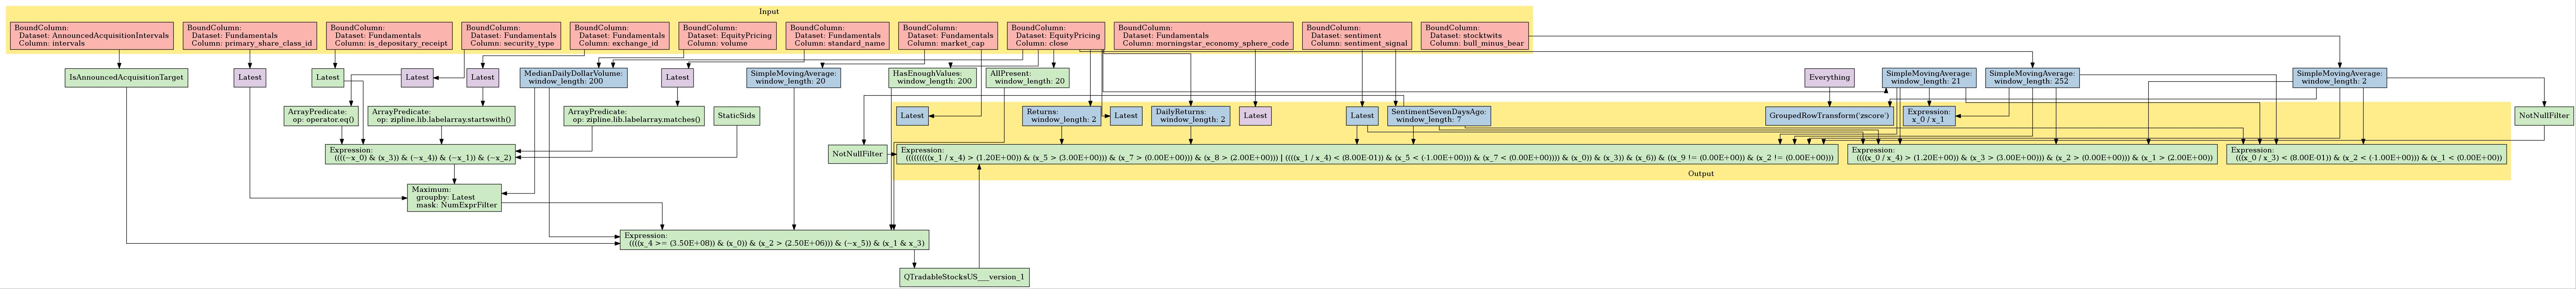

In [4]:
# pipeline_output['return'] = pd.get_dummies(pipeline_output['return'],drop_first=True)
# pipeline_output.head(30)
make_pipeline().show_graph(format='jpeg') #or png

## Feature Engineering

In [8]:
# return_encoding = pd.get_dummies(pipeline_output['return'],drop_first=True)
# pipeline_output['return'] = return_encoding
# pipeline_output['Returns'] = pipeline_output["Returns"].apply(np.sign)

pipeline_output['return'] = pipeline_output["return"].apply(np.sign)
pipeline_output['Market Capital.'] = pipeline_output["Market Capital."].apply(np.log)
# Applied zscore to Market Capitalization but got an outlier which was Apple stock

In [9]:
pipeline_output.head(10)

BUY       MAD  \
2013-01-03 00:00:00+00:00 Equity(754 [BBY])     False  0.630091   
2013-01-04 00:00:00+00:00 Equity(754 [BBY])     False  0.629542   
                          Equity(3645 [HOV])     True  1.890448   
2013-01-07 00:00:00+00:00 Equity(754 [BBY])     False  0.631212   
                          Equity(3212 [GILD])    True  1.307798   
                          Equity(32902 [FSLR])   True  1.287577   
2013-01-08 00:00:00+00:00 Equity(3212 [GILD])    True  1.306559   
                          Equity(3645 [HOV])     True  1.918963   
2013-01-09 00:00:00+00:00 Equity(3212 [GILD])    True  1.306288   
2013-01-10 00:00:00+00:00 Equity(14848 [AABA])   True  1.218424   

                                                Market Capital.   Returns  \
2013-01-03 00:00:00+00:00 Equity(754 [BBY])           22.111144 -0.004219   
2013-01-04 00:00:00+00:00 Equity(754 [BBY])           22.111144  0.013559   
                          Equity(3645 [HOV])          20.662923  0.010130   
2013-01-07 00:00:00+00:00 Equity(754 [BBY])           22.111144  0.011706   
                          Equity(3212 [GILD])         24.744883  0.010538   
                          Equity(32902 [FSLR])        21.712406 -0.024695   
2013-01-08 00:00:00+00:00 Equity(3212 [GILD])         24.744883  0.014916   
                          Equity(3645 [HOV])          20.662923 -0.043353   
2013-01-09 00:00:00+00:00 Equity(3212 [GILD])         24.744883  0.005202   
2013-01-10 00:00:00+00:00 Equity(14848 [AABA])        23.823049 -0.018293   

                                                SHORT  Sentdex  Sentdex_lag  \
2013-01-03 00:00:00+00:00 Equity(754 [BBY])      True     -3.0         -3.0   
2013-01-04 00:00:00+00:00 Equity(754 [BBY])      True     -1.0         -3.0   
                          Equity(3645 [HOV])    False      3.0          6.0   
2013-01-07 00:00:00+00:00 Equity(754 [BBY])      True     -1.0         -3.0   
                          Equity(3212 [GILD])   False      6.0          6.0   
                          Equity(32902 [FSLR])  False      6.0          4.0   
2013-01-08 00:00:00+00:00 Equity(3212 [GILD])   False      6.0          4.0   
                          Equity(3645 [HOV])    False      3.0          6.0   
2013-01-09 00:00:00+00:00 Equity(3212 [GILD])   False      6.0          4.0   
2013-01-10 00:00:00+00:00 Equity(14848 [AABA])  False      3.0          6.0   

                                                Stock Classfiaction  \
2013-01-03 00:00:00+00:00 Equity(754 [BBY])                       1   
2013-01-04 00:00:00+00:00 Equity(754 [BBY])                       1   
                          Equity(3645 [HOV])                      1   
2013-01-07 00:00:00+00:00 Equity(754 [BBY])                       1   
                          Equity(3212 [GILD])                     2   
                          Equity(32902 [FSLR])                    3   
2013-01-08 00:00:00+00:00 Equity(3212 [GILD])                     2   
                          Equity(3645 [HOV])                      1   
2013-01-09 00:00:00+00:00 Equity(3212 [GILD])                     2   
2013-01-10 00:00:00+00:00 Equity(14848 [AABA])                    3   

                                                close_price  return  \
2013-01-03 00:00:00+00:00 Equity(754 [BBY])           11.80    -1.0   
2013-01-04 00:00:00+00:00 Equity(754 [BBY])           11.96     1.0   
                          Equity(3645 [HOV])           6.98     1.0   
2013-01-07 00:00:00+00:00 Equity(754 [BBY])           12.10     1.0   
                          Equity(3212 [GILD])         75.76     1.0   
                          Equity(32902 [FSLR])        33.57    -1.0   
2013-01-08 00:00:00+00:00 Equity(3212 [GILD])         76.89     1.0   
                          Equity(3645 [HOV])           6.62    -1.0   
2013-01-09 00:00:00+00:00 Equity(3212 [GILD])         77.29     1.0   
2013-01-10 00:00:00+00:00 Equity(14848 [AABA])        19.32    -1.0   

                              

In [10]:
pipeline_output["Trading Signal"] = pd.get_dummies(pipeline_output['BUY'],drop_first=True)

pipeline_output.tail(20)
# if BUY "FALSE" --> 0 | if BUY "TRUE" --> 1

BUY       MAD  \
2016-12-30 00:00:00+00:00 Equity(15789 [DNR])   True  1.316933   
                          Equity(21418 [MET])   True  1.257716   
                          Equity(24475 [CME])   True  1.210884   
                          Equity(33698 [TMUS])  True  1.287221   
                          Equity(34011 [DFS])   True  1.285712   
                          Equity(34913 [RF])    True  1.491888   
2017-01-03 00:00:00+00:00 Equity(455 [APC])     True  1.325305   
                          Equity(1335 [C])      True  1.288723   
                          Equity(1937 [CSX])    True  1.316331   
                          Equity(2127 [DE])     True  1.234021   
                          Equity(2938 [S])      True  1.659089   
                          Equity(4498 [LNC])    True  1.461184   
                          Equity(4580 [JEF])    True  1.304419   
                          Equity(5117 [MTB])    True  1.302449   
                          Equity(6068 [PNC])    True  1.288326   
                          Equity(7152 [STI])    True  1.304806   
                          Equity(15789 [DNR])   True  1.312375   
                          Equity(21418 [MET])   True  1.255691   
                          Equity(33698 [TMUS])  True  1.288627   
                          Equity(34913 [RF])    True  1.493173   

                                                Market Capital.   Returns  \
2016-12-30 00:00:00+00:00 Equity(15789 [DNR])         21.122066 -0.014512   
                          Equity(21418 [MET])         24.803063 -0.003335   
                          Equity(24475 [CME])         24.392593 -0.003191   
                          Equity(33698 [TMUS])        24.591005  0.000862   
                          Equity(34011 [DFS])         24.067453 -0.000695   
                          Equity(34913 [RF])          23.582199 -0.016984   
2017-01-03 00:00:00+00:00 Equity(455 [APC])           24.386113 -0.005562   
                          Equity(1335 [C])            25.855289  0.000842   
                          Equity(1937 [CSX])          24.239405 -0.008004   
                          Equity(2127 [DE])           24.209128 -0.001163   
                          Equity(2938 [S])            24.235477 -0.044268   
                          Equity(4498 [LNC])          23.441048  0.002117   
                          Equity(4580 [JEF])          22.847981  0.002155   
                          Equity(5117 [MTB])          23.911858  0.005204   
                          Equity(6068 [PNC])          24.764583  0.007407   
                          Equity(7152 [STI])          24.016145  0.002925   
                          Equity(15789 [DNR])         21.105893 -0.014726   
                          Equity(21418 [MET])         24.804735  0.002045   
                          Equity(33698 [TMUS])        24.581659 -0.009302   
                          Equity(34913 [RF])          23.595519  0.013399   

                                                SHORT  Sentdex  Sentdex_lag  \
2016-12-30 00:00:00+00:00 Equity(15789 [DNR])   False      6.0          6.0   
                          Equity(21418 [MET])   False      6.0          6.0   
                          Equity(24475 [CME])   False      5.0          5.0   
                          Equity(33698 [TMUS])  False      4.0          4.0   
                          Equity(34011 [DFS])   False      5.0          6.0   
                          Equity(34913 [RF])    False      5.0          5.0   
2017-01-03 00:00:00+00:00 Equity(455 [APC])     False      4.0          4.0   
                          Equity(1335 [C])      False      4.0          4.0   
                          Equity(1937 [CSX])    False      6.0          6.0   
                          Equity(2127 [DE])     False      6.0          5.0   
                          Equity(2938 [S])      False      4.0          6.0   
                          Equity(4498 [LNC])    False      5.0          5.0   
                 

## Data Analysis and Insights Generation

In [11]:
n=float(len(pipeline_output[pipeline_output["return"]>0]))
m=float(len(pipeline_output[pipeline_output["Trading Signal"]==1]))
a=float(len(pipeline_output[pipeline_output["return"]<0]))
b=float(len(pipeline_output[pipeline_output["Trading Signal"]==0]))
z=float(len(pipeline_output))
print"The percentage of positive returns is:", ((n/z)*100),"%"
print"The percentage of BUY Trading Signal is:", ((m/z)*100),"%"
print"The percentage of negative returns is:", ((a/z)*100),"%"
print"The percentage of SELL Trading Signal is:", ((b/z)*100),"%"


The percentage of positive returns is: 52.7910892371 %
The percentage of BUY Trading Signal is: 79.406812589 %
The percentage of negative returns is: 47.2089107629 %
The percentage of SELL Trading Signal is: 20.593187411 %


In [12]:
print(pipeline_output['Trading Signal'].value_counts())
print(pipeline_output['return'].value_counts())

#Unbalanced labels and datasets

1.0    6131
0.0    1590
Name: Trading Signal, dtype: int64
 1.0    4076
-1.0    3645
Name: return, dtype: int64


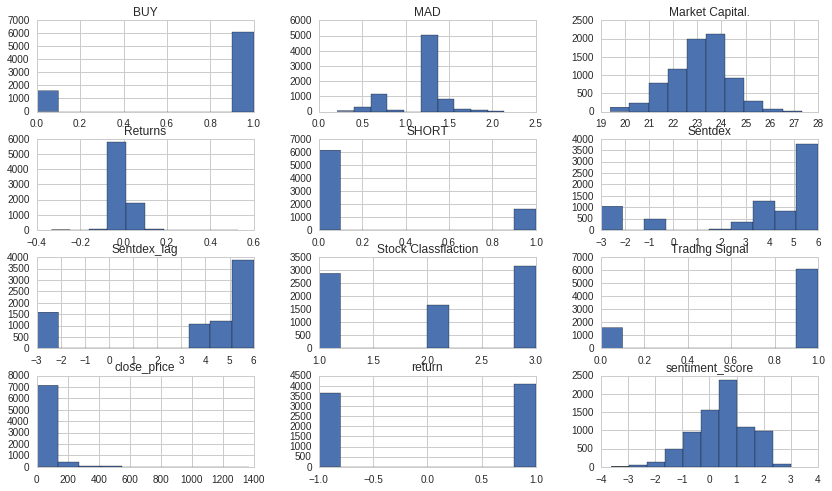

In [13]:
pipeline_output.hist();

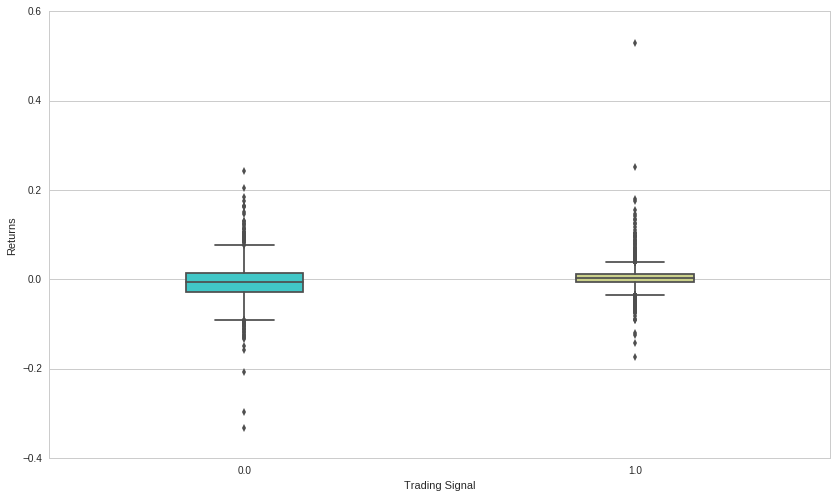

In [14]:
sns.boxplot(x='Trading Signal',y='Returns',data=pipeline_output,palette='rainbow', width= 0.3);
# For which I assigned buy (1), what where their returns
# For which I assigned sell(0), what where their returns

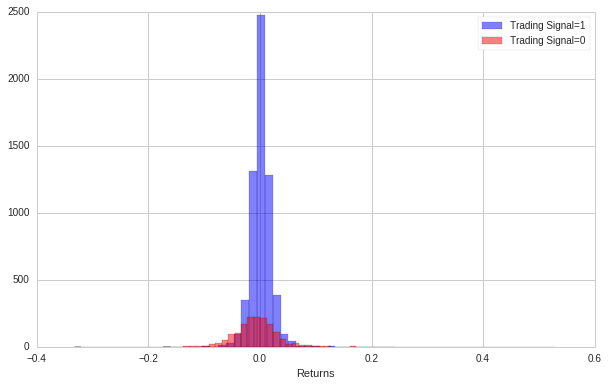

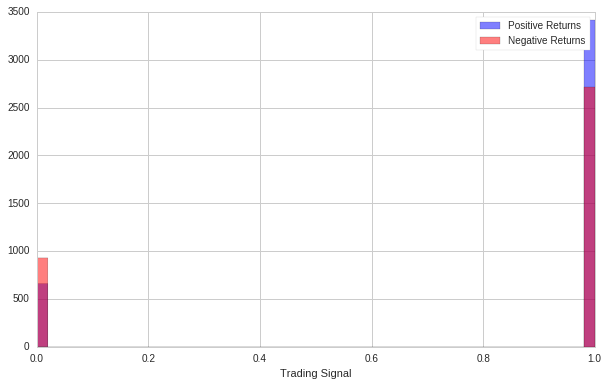

In [15]:
plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Trading Signal']==1]["Returns"].hist(alpha=0.5,color='blue',
                                              bins=50,label='Trading Signal=1')
pipeline_output[pipeline_output['Trading Signal']==0]['Returns'].hist(alpha=0.5,color='red',
                                              bins=50,label='Trading Signal=0')
plt.legend()
plt.xlabel('Returns');

plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Returns']>0]["Trading Signal"].hist(alpha=0.5,color='blue',
                                              bins=50,label='Positive Returns')
pipeline_output[pipeline_output['Returns']<0]['Trading Signal'].hist(alpha=0.5,color='red',
                                              bins=50,label='Negative Returns')
plt.legend()
plt.xlabel('Trading Signal');

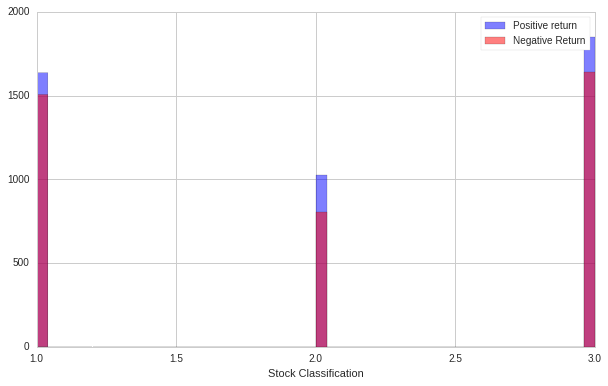

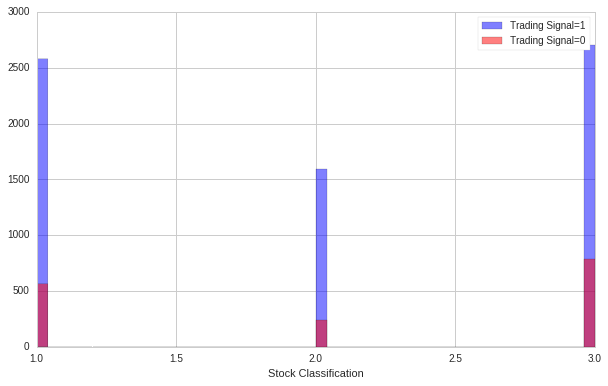

In [74]:
plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Returns']>0]['Stock Classfiaction'].hist(alpha=0.5,color='blue',
                                              bins=50,label='Positive return')
pipeline_output[pipeline_output['Returns']<0]['Stock Classfiaction'].hist(alpha=0.5,color='red',
                                              bins=50,label='Negative Return')
plt.legend()
plt.xlabel('Stock Classification');

plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Trading Signal']==1]['Stock Classfiaction'].hist(alpha=0.5,color='blue',
                                              bins=50,label='Trading Signal=1')
pipeline_output[pipeline_output['Trading Signal']==0]['Stock Classfiaction'].hist(alpha=0.5,color='red',
                                              bins=50,label='Trading Signal=0')
plt.legend()
plt.xlabel('Stock Classification');

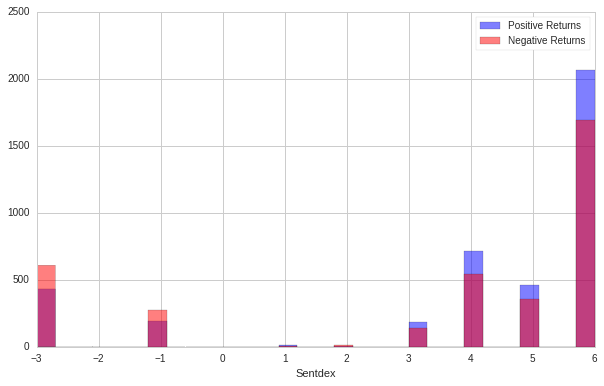

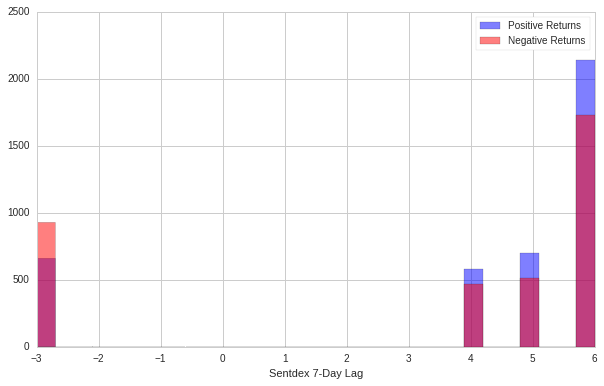

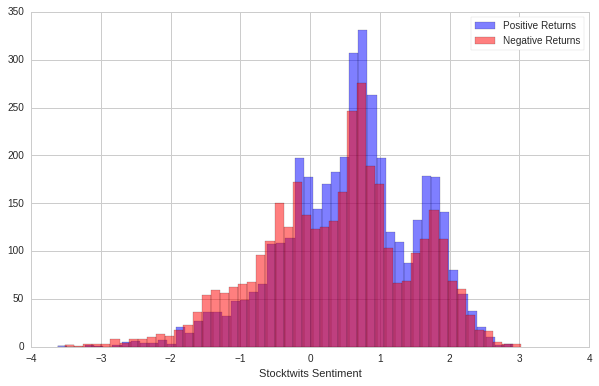

In [16]:
plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Returns']>0]['Sentdex'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Positive Returns')
pipeline_output[pipeline_output['Returns']<0]['Sentdex'].hist(alpha=0.5,color='red',
                                              bins=30,label='Negative Returns')
plt.legend()
plt.xlabel('Sentdex');

plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Returns']>0]['Sentdex_lag'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Positive Returns')
pipeline_output[pipeline_output['Returns']<0]['Sentdex_lag'].hist(alpha=0.5,color='red',
                                              bins=30,label='Negative Returns')
plt.legend()
plt.xlabel('Sentdex 7-Day Lag');

plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Returns']>0]['sentiment_score'].hist(alpha=0.5,color='blue',
                                              bins=50,label='Positive Returns')
pipeline_output[pipeline_output['Returns']<0]['sentiment_score'].hist(alpha=0.5,color='red',
                                              bins=50,label='Negative Returns')
plt.legend()
plt.xlabel('Stocktwits Sentiment');

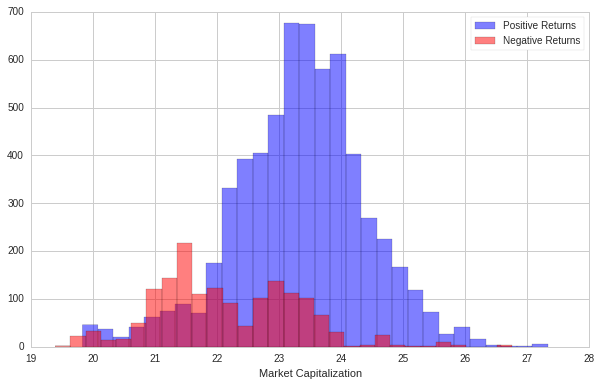

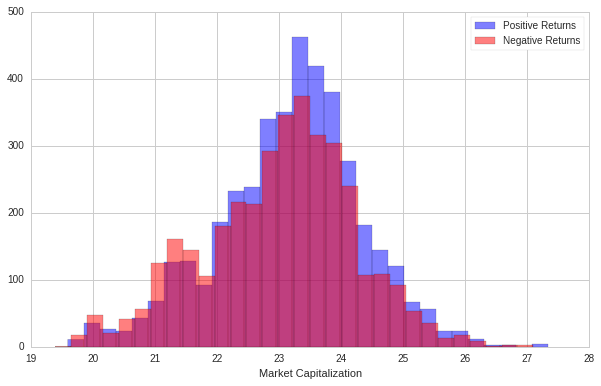

In [17]:
plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Trading Signal']==1]['Market Capital.'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Positive Returns')
pipeline_output[pipeline_output['Trading Signal']==0]['Market Capital.'].hist(alpha=0.5,color='red',
                                              bins=30,label='Negative Returns')
plt.legend()
plt.xlabel('Market Capitalization');

plt.figure(figsize=(10,6))
pipeline_output[pipeline_output['Returns']>0]['Market Capital.'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Positive Returns')
pipeline_output[pipeline_output['Returns']<0]['Market Capital.'].hist(alpha=0.5,color='red',
                                              bins=30,label='Negative Returns')
plt.legend()
plt.xlabel('Market Capitalization');

In [18]:
print('Number of securities that passed the filter: %d' % len(pipeline_output.index.levels[1].unique()))
pipeline_output.columns

Number of securities that passed the filter: 365


Index([u'BUY', u'MAD', u'Market Capital.', u'Returns', u'SHORT', u'Sentdex',
       u'Sentdex_lag', u'Stock Classfiaction', u'close_price', u'return',
       u'sentiment_score', u'Trading Signal'],
      dtype='object')

In [19]:
pipeline_output.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7721 entries, (2013-01-03 00:00:00+00:00, Equity(754 [BBY])) to (2017-01-03 00:00:00+00:00, Equity(34913 [RF]))
Data columns (total 12 columns):
BUY                    7721 non-null bool
MAD                    7721 non-null float64
Market Capital.        7721 non-null float64
Returns                7721 non-null float64
SHORT                  7721 non-null bool
Sentdex                7721 non-null float64
Sentdex_lag            7721 non-null float64
Stock Classfiaction    7721 non-null int64
close_price            7721 non-null float64
return                 7721 non-null float64
sentiment_score        7721 non-null float64
Trading Signal         7721 non-null float64
dtypes: bool(2), float64(9), int64(1)
memory usage: 678.6+ KB


#                          ********BUILDING THE MODEL PHASE********


In [20]:
from sklearn.linear_model import LogisticRegression
# Testing how the model's intuition 
model = LogisticRegression()
model.fit([[-2,-3],[1,0],[1,1]],["T","F","T"])
# model.coef_, model.intercept_,model.predict([-3,21])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [21]:
feature_cols = ["Market Capital.", "sentiment_score", "Sentdex_lag","MAD","Trading Signal", "Stock Classfiaction", "Sentdex"]
X = pipeline_output[feature_cols]
y = pipeline_output["return"] #target column (classified T or F)

In [22]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state= None)

In [23]:
# instantiate the model (using the default parameters)
logmodel = LogisticRegression()
# fit the model with data
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [24]:
#
y_pred=logmodel.predict(X_test)
y_pred
logmodel.coef_, logmodel.intercept_,logmodel.predict(X_test)

(array([[ 0.03232106,  0.05241236,  0.04652156,  0.35667146, -0.09948144,
          0.02811701, -0.01375332]]),
 array([-1.17619271]),
 array([-1., -1.,  1., ...,  1., -1.,  1.]))

In [25]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 367, 1087],
       [ 255, 1380]])

In [26]:
print"Accuracy:",metrics.accuracy_score(y_test, y_pred)
print"Precision:",metrics.precision_score(y_test, y_pred)
print"Recall:",metrics.recall_score(y_test, y_pred)

Accuracy: 0.565555195856
Precision: 0.559383867045
Recall: 0.844036697248


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

       -1.0       0.59      0.25      0.35      1454
        1.0       0.56      0.84      0.67      1635

avg / total       0.57      0.57      0.52      3089



## Determine Threshold

In [42]:

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

THRESHOLD = 0.50
preds = np.where(logmodel.predict_proba(X_test)[:,1] > THRESHOLD, 1, -1)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns = ["Scores"])
# 0.5 remained the best threshold

,Scores
accuracy,0.565555
recall,0.844037
precision,0.559384
roc_auc_score,0.548222


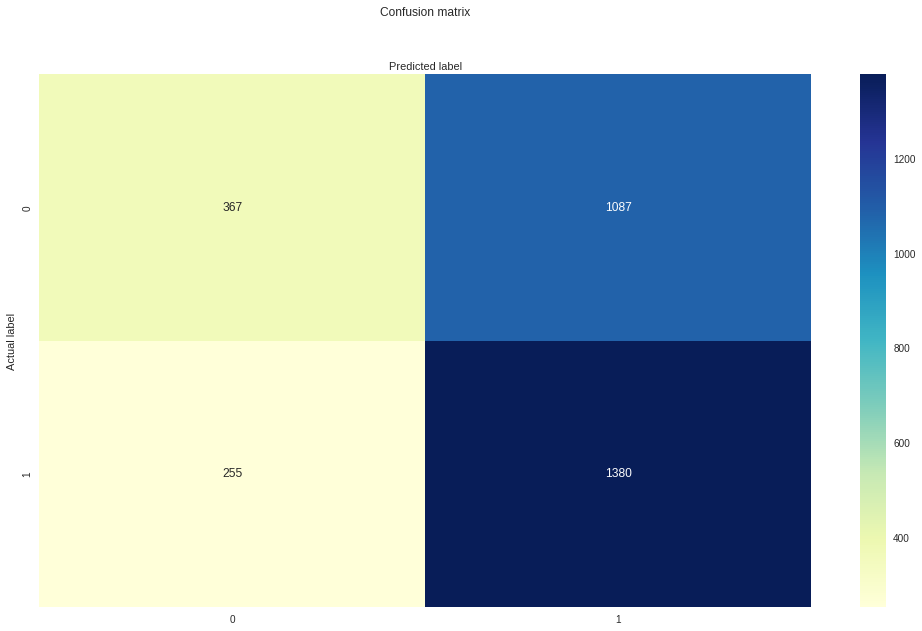

In [43]:
class_names=[-1,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

AUROC represents the likelihood of the model distinguishing observations from two classes.
In other words, if a random selection of an observation from each class is made, what's the probability that your model will be able to "rank" them correctly?

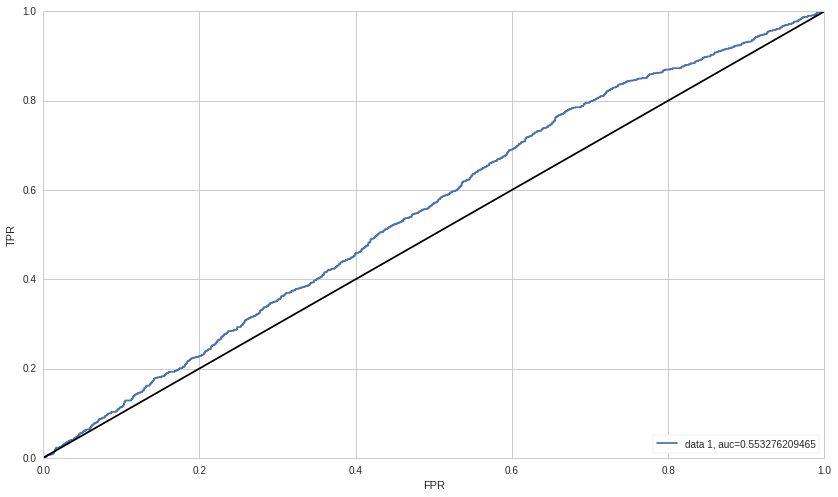

In [44]:
y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, threshold = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
x = np.linspace(0, 1, 100000)
plt.plot(x, x + 0, linestyle='solid',c = 'k')
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


### Random Forest Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_leaf_nodes=2,max_features=7, min_samples_split=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=2,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
rfc_pred = rfc.predict(X_test)
rfc_pred
cnf_matrix = metrics.confusion_matrix(y_test, rfc_pred)
cnf_matrix


array([[ 393, 1061],
       [ 286, 1349]])

In [62]:
print("Accuracy:",metrics.accuracy_score(y_test, rfc_pred))
print("Precision:",metrics.precision_score(y_test, rfc_pred))
print("Recall:",metrics.recall_score(y_test, rfc_pred))


('Accuracy:', 0.56393654904499835)
('Precision:', 0.55975103734439835)
('Recall:', 0.82507645259938833)


In [63]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

       -1.0       0.59      0.25      0.35      1454
        1.0       0.56      0.84      0.67      1635

avg / total       0.57      0.57      0.52      3089



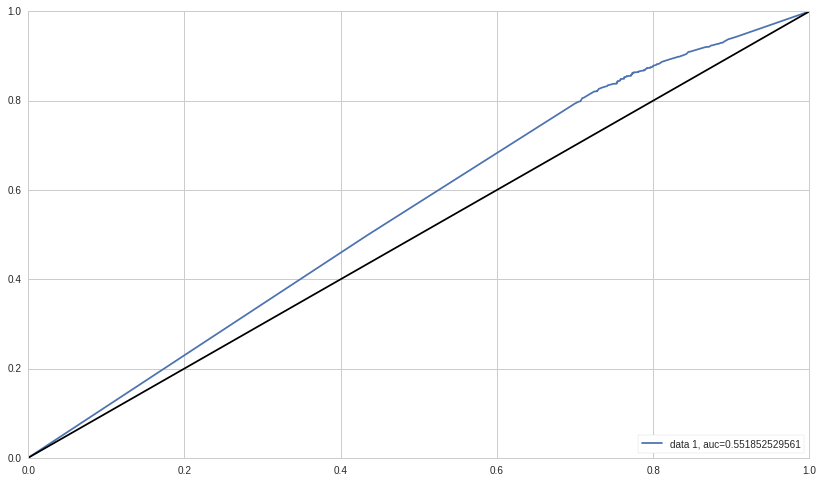

In [64]:
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
x = np.linspace(0, 1, 100000)
plt.plot(x, x + 0, linestyle='solid',c = 'k')
plt.legend(loc=4)
plt.show()

### Out of Sample Predictions:

In [65]:
pipeline_outsample = run_pipeline(
    make_pipeline(),
    start_date="2017-01-01", 
    end_date="2018-01-01"
)
pipeline_outsample.head(20)

BUY       MAD  \
2017-01-03 00:00:00+00:00 Equity(455 [APC])     True  1.325305   
                          Equity(1335 [C])      True  1.288723   
                          Equity(1937 [CSX])    True  1.316331   
                          Equity(2127 [DE])     True  1.234021   
                          Equity(2938 [S])      True  1.659089   
                          Equity(4498 [LNC])    True  1.461184   
                          Equity(4580 [JEF])    True  1.304419   
                          Equity(5117 [MTB])    True  1.302449   
                          Equity(6068 [PNC])    True  1.288326   
                          Equity(7152 [STI])    True  1.304806   
                          Equity(15789 [DNR])   True  1.312375   
                          Equity(21418 [MET])   True  1.255691   
                          Equity(33698 [TMUS])  True  1.288627   
                          Equity(34913 [RF])    True  1.493173   
2017-01-04 00:00:00+00:00 Equity(455 [APC])     True  1.324733   
                          Equity(1335 [C])      True  1.291020   
                          Equity(2127 [DE])     True  1.233353   
                          Equity(4580 [JEF])    True  1.304112   
                          Equity(4831 [MGM])    True  1.230425   
                          Equity(5117 [MTB])    True  1.304517   

                                                Market Capital.   Returns  \
2017-01-03 00:00:00+00:00 Equity(455 [APC])        3.897216e+10 -0.005562   
                          Equity(1335 [C])         1.693595e+11  0.000842   
                          Equity(1937 [CSX])       3.365423e+10 -0.008004   
                          Equity(2127 [DE])        3.265056e+10 -0.001163   
                          Equity(2938 [S])         3.352232e+10 -0.044268   
                          Equity(4498 [LNC])       1.514669e+10  0.002117   
                          Equity(4580 [JEF])       8.370510e+09  0.002155   
                          Equity(5117 [MTB])       2.425426e+10  0.005204   
                          Equity(6068 [PNC])       5.690122e+10  0.007407   
                          Equity(7152 [STI])       2.692026e+10  0.002925   
                          Equity(15789 [DNR])      1.466132e+09 -0.014726   
                          Equity(21418 [MET])      5.923241e+10  0.002045   
                          Equity(33698 [TMUS])     4.738913e+10 -0.009302   
                          Equity(34913 [RF])       1.767680e+10  0.013399   
2017-01-04 00:00:00+00:00 Equity(455 [APC])        3.926279e+10  0.007457   
                          Equity(1335 [C])         1.726652e+11  0.019350   
                          Equity(2127 [DE])        3.297060e+10  0.009656   
                          Equity(4580 [JEF])       8.388512e+09  0.002151   
                          Equity(4831 [MGM])       1.690285e+10  0.022199   
                          Equity(5117 [MTB])       2.430232e+10  0.001917   

                                                SHORT  Sentdex  Sentdex_lag  \
2017-01-03 00:00:00+00:00 Equity(455 [APC])     False      4.0          4.0   
                          Equity(1335 [C])      False      4.0          4.0   
                          Equity(1937 [CSX])    False      6.0          6.0   
                          Equity(2127 [DE])     False      6.0          5.0   
                          Equity(2938 [S])      False      4.0          6.0   
                          Equity(4498 [LNC])    False      5.0          5.0   
                          Equity(4580 [JEF])    False      6.0          6.0   
                          Equity(5117 [MTB])    False      3.0          5.0   
                          Equity(6068 [PNC])    False      5.0          5.0   
                          Equity(7152 [STI])    False      6.0          6.0   
                          Equity(15789 [DNR])   False      6.0          6.0   
                          Equity(21418 [MET])   False      6.0          6.0   
                 

In [66]:
pipeline_outsample['return'] = pipeline_outsample["return"].apply(np.sign)


In [67]:
pipeline_outsample["Trading Signal"]  = pd.get_dummies(pipeline_outsample['BUY'],drop_first=True)


In [68]:
pipeline_outsample['Market Capital.'] = pipeline_outsample["Market Capital."].apply(np.log)

pipeline_outsample.head(20)

BUY       MAD  \
2017-01-03 00:00:00+00:00 Equity(455 [APC])     True  1.325305   
                          Equity(1335 [C])      True  1.288723   
                          Equity(1937 [CSX])    True  1.316331   
                          Equity(2127 [DE])     True  1.234021   
                          Equity(2938 [S])      True  1.659089   
                          Equity(4498 [LNC])    True  1.461184   
                          Equity(4580 [JEF])    True  1.304419   
                          Equity(5117 [MTB])    True  1.302449   
                          Equity(6068 [PNC])    True  1.288326   
                          Equity(7152 [STI])    True  1.304806   
                          Equity(15789 [DNR])   True  1.312375   
                          Equity(21418 [MET])   True  1.255691   
                          Equity(33698 [TMUS])  True  1.288627   
                          Equity(34913 [RF])    True  1.493173   
2017-01-04 00:00:00+00:00 Equity(455 [APC])     True  1.324733   
                          Equity(1335 [C])      True  1.291020   
                          Equity(2127 [DE])     True  1.233353   
                          Equity(4580 [JEF])    True  1.304112   
                          Equity(4831 [MGM])    True  1.230425   
                          Equity(5117 [MTB])    True  1.304517   

                                                Market Capital.   Returns  \
2017-01-03 00:00:00+00:00 Equity(455 [APC])           24.386113 -0.005562   
                          Equity(1335 [C])            25.855289  0.000842   
                          Equity(1937 [CSX])          24.239405 -0.008004   
                          Equity(2127 [DE])           24.209128 -0.001163   
                          Equity(2938 [S])            24.235477 -0.044268   
                          Equity(4498 [LNC])          23.441048  0.002117   
                          Equity(4580 [JEF])          22.847981  0.002155   
                          Equity(5117 [MTB])          23.911858  0.005204   
                          Equity(6068 [PNC])          24.764583  0.007407   
                          Equity(7152 [STI])          24.016145  0.002925   
                          Equity(15789 [DNR])         21.105893 -0.014726   
                          Equity(21418 [MET])         24.804735  0.002045   
                          Equity(33698 [TMUS])        24.581659 -0.009302   
                          Equity(34913 [RF])          23.595519  0.013399   
2017-01-04 00:00:00+00:00 Equity(455 [APC])           24.393543  0.007457   
                          Equity(1335 [C])            25.874620  0.019350   
                          Equity(2127 [DE])           24.218882  0.009656   
                          Equity(4580 [JEF])          22.850129  0.002151   
                          Equity(4831 [MGM])          23.550748  0.022199   
                          Equity(5117 [MTB])          23.913838  0.001917   

                                                SHORT  Sentdex  Sentdex_lag  \
2017-01-03 00:00:00+00:00 Equity(455 [APC])     False      4.0          4.0   
                          Equity(1335 [C])      False      4.0          4.0   
                          Equity(1937 [CSX])    False      6.0          6.0   
                          Equity(2127 [DE])     False      6.0          5.0   
                          Equity(2938 [S])      False      4.0          6.0   
                          Equity(4498 [LNC])    False      5.0          5.0   
                          Equity(4580 [JEF])    False      6.0          6.0   
                          Equity(5117 [MTB])    False      3.0          5.0   
                          Equity(6068 [PNC])    False      5.0          5.0   
                          Equity(7152 [STI])    False      6.0          6.0   
                          Equity(15789 [DNR])   False      6.0          6.0   
                          Equity(21418 [MET])   False      6.0          6.0   
                 

In [69]:
X_ofs17 = pipeline_outsample[feature_cols]
y_ofs17 = pipeline_outsample["return"]
len(X_ofs17)

2353

#### Fitting Logestic Model to out of sample data:

In [70]:
y_pred_ofs17 = logmodel.predict(X_ofs17)
y_pred_ofs17

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [78]:
cnf_matrix = metrics.confusion_matrix(y_ofs17, y_pred_ofs17)
print cnf_matrix    
print"Accuracy:",metrics.accuracy_score(y_ofs17, y_pred_ofs17)
print"Precision:",metrics.precision_score(y_ofs17, y_pred_ofs17)
print"Recall:",metrics.recall_score(y_ofs17, y_pred_ofs17)
print classification_report(y_ofs17,y_pred_ofs17)

[[ 282  795]
 [ 239 1037]]
Accuracy: 0.560560985975
Precision: 0.566048034934
Recall: 0.812695924765
             precision    recall  f1-score   support

       -1.0       0.54      0.26      0.35      1077
        1.0       0.57      0.81      0.67      1276

avg / total       0.55      0.56      0.52      2353



#### Fitting Random Forest Classifier to out of sample data:

In [76]:
y_rfc_pred_ofs_17 = rfc.predict(X_ofs17)
y_rfc_pred_ofs_17

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [77]:
cnf_matrix_rfc = metrics.confusion_matrix(y_ofs17, y_rfc_pred_ofs_17)
print(cnf_matrix_rfc)
print("Accuracy:",metrics.accuracy_score(y_ofs17, y_rfc_pred_ofs_17))
print("Precision:",metrics.precision_score(y_ofs17, y_rfc_pred_ofs_17))
print("Recall:",metrics.recall_score(y_ofs17, y_rfc_pred_ofs_17))
print classification_report(y_ofs17,y_rfc_pred_ofs_17)

[[ 306  771]
 [ 259 1017]]
('Accuracy:', 0.56226094347641309)
('Precision:', 0.56879194630872487)
('Recall:', 0.79702194357366773)
             precision    recall  f1-score   support

       -1.0       0.54      0.28      0.37      1077
        1.0       0.57      0.80      0.66      1276

avg / total       0.56      0.56      0.53      2353



# Stepping Up a year and refitting both models:

In [79]:
pipeline_output_2 = run_pipeline(
    make_pipeline(),
    start_date="2014-01-01", 
    end_date="2018-01-01"
)

In [80]:
pipeline_output_2['return'] = pipeline_output_2["return"].apply(np.sign)
pipeline_output_2['Market Capital.'] = pipeline_output_2["Market Capital."].apply(np.log)
pipeline_output_2["Trading Signal"] = pd.get_dummies(pipeline_output_2['BUY'],drop_first=True)
 

In [81]:
n=float(len(pipeline_output_2[pipeline_output_2["return"]>0]))
m=float(len(pipeline_output_2[pipeline_output_2["Trading Signal"]==1]))
a=float(len(pipeline_output_2[pipeline_output_2["return"]<0]))
b=float(len(pipeline_output_2[pipeline_output_2["Trading Signal"]==0]))
x=float(len(pipeline_output_2[pipeline_output_2["Returns"]>0]))
y=float(len(pipeline_output_2[pipeline_output_2["Returns"]<0]))
z=float(len(pipeline_output))
print"The percentage of positive returns is:", ((n/z)*100),"%"
print"The percentage of BUY Trading Signal is:", ((m/z)*100),"%"
print"The percentage of negative returns is:", ((a/z)*100),"%"
print"The percentage of SELL Trading Signal is:", ((b/z)*100),"%"


The percentage of positive returns is: 46.2763890688 %
The percentage of BUY Trading Signal is: 63.644605621 %
The percentage of negative returns is: 43.970988214 %
The percentage of SELL Trading Signal is: 26.6027716617 %


In [82]:
pipeline_output_2.tail(20)

BUY       MAD  \
2017-12-29 00:00:00+00:00 Equity(24124 [WYNN])  True  1.279001   
                          Equity(24811 [GES])   True  1.273858   
                          Equity(24832 [RL])    True  1.201872   
                          Equity(25920 [MAR])   True  1.273396   
                          Equity(27676 [AMP])   True  1.234831   
                          Equity(32902 [FSLR])  True  1.555720   
                          Equity(41636 [MPC])   True  1.214153   
2018-01-02 00:00:00+00:00 Equity(114 [ADBE])    True  1.215385   
                          Equity(1267 [CAT])    True  1.331272   
                          Equity(1539 [CI])     True  1.202831   
                          Equity(1941 [CTAS])   True  1.204947   
                          Equity(3321 [GPS])    True  1.343680   
                          Equity(6546 [ROST])   True  1.221500   
                          Equity(7590 [TROW])   True  1.294825   
                          Equity(23269 [WW])    True  1.481039   
                          Equity(24124 [WYNN])  True  1.280397   
                          Equity(24811 [GES])   True  1.272976   
                          Equity(24832 [RL])    True  1.206513   
                          Equity(27676 [AMP])   True  1.234680   
                          Equity(32902 [FSLR])  True  1.559013   

                                                Market Capital.   Returns  \
2017-12-29 00:00:00+00:00 Equity(24124 [WYNN])        23.585159 -0.010077   
                          Equity(24811 [GES])         21.078006 -0.011541   
                          Equity(24832 [RL])          22.851096 -0.002140   
                          Equity(25920 [MAR])         24.628752  0.002422   
                          Equity(27676 [AMP])         23.953562  0.004271   
                          Equity(32902 [FSLR])        22.695841 -0.006538   
                          Equity(41636 [MPC])         24.202668 -0.000301   
2018-01-02 00:00:00+00:00 Equity(114 [ADBE])          25.178645 -0.001424   
                          Equity(1267 [CAT])          25.263894 -0.005301   
                          Equity(1539 [CI])           24.636723 -0.010037   
                          Equity(1941 [CTAS])         23.532140 -0.004980   
                          Equity(3321 [GPS])          23.306846 -0.010456   
                          Equity(6546 [ROST])         24.146460 -0.004094   
                          Equity(7590 [TROW])         23.959022 -0.003987   
                          Equity(23269 [WW])          21.773177 -0.064942   
                          Equity(24124 [WYNN])        23.575596  0.000831   
                          Equity(24811 [GES])         21.051696 -0.014594   
                          Equity(24832 [RL])          22.854768  0.010624   
                          Equity(27676 [AMP])         23.944926 -0.012584   
                          Equity(32902 [FSLR])        22.676480 -0.012723   

                                                SHORT  Sentdex  Sentdex_lag  \
2017-12-29 00:00:00+00:00 Equity(24124 [WYNN])  False      4.0          6.0   
                          Equity(24811 [GES])   False      6.0          6.0   
                          Equity(24832 [RL])    False      4.0          4.0   
                          Equity(25920 [MAR])   False      6.0          5.0   
                          Equity(27676 [AMP])   False      4.0          4.0   
                          Equity(32902 [FSLR])  False      6.0          4.0   
                          Equity(41636 [MPC])   False      6.0          6.0   
2018-01-02 00:00:00+00:00 Equity(114 [ADBE])    False      6.0          6.0   
                          Equity(1267 [CAT])    False      6.0          6.0   
                          Equity(1539 [CI])     False      5.0          5.0   
                          Equity(1941 [CTAS])   False      4.0          4.0   
                          Equity(3321 [GPS])    False      5.0          5.0   
                 

In [83]:
X_1 = pipeline_output_2[feature_cols]
y_1 = pipeline_output_2["return"]

In [84]:
X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X_1,y_1,test_size=0.2,random_state= None)

#### Fit New Logestic Model

In [85]:
# instantiate the model (using the default parameters)
logmodel_2 = LogisticRegression()
# fit the model with data
logmodel_2.fit(X_train_1,y_train_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [86]:
y_pred_1=logmodel.predict(X_test_1)
y_pred_1

array([-1., -1.,  1., ...,  1.,  1.,  1.])

In [87]:
cnf_matrix_1 = metrics.confusion_matrix(y_test_1, y_pred_1)
print(cnf_matrix_1)
print"Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1)
print"Precision:",metrics.precision_score(y_test_1, y_pred_1)
print"Recall:",metrics.recall_score(y_test_1, y_pred_1)
print classification_report(y_test_1,y_pred_1)

[[230 433]
 [175 556]]
Accuracy: 0.563845050215
Precision: 0.562184024267
Recall: 0.760601915185
             precision    recall  f1-score   support

       -1.0       0.57      0.35      0.43       663
        1.0       0.56      0.76      0.65       731

avg / total       0.56      0.56      0.54      1394



### Fit New Random Forest Classifier Model

In [88]:
rfc_2 = RandomForestClassifier(n_estimators=100, max_leaf_nodes=2,max_features=7, min_samples_split=1)
rfc_2.fit(X_train_1, y_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=2,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
rfc_pred_2 = rfc.predict(X_test_1)
rfc_pred_2
cnf_matrix_1 = metrics.confusion_matrix(y_test_1, rfc_pred_2)
print cnf_matrix_1
print "Accuracy:",metrics.accuracy_score(y_test_1, rfc_pred_2)
print "Precision:",metrics.precision_score(y_test_1, rfc_pred_2)
print "Recall:",metrics.recall_score(y_test_1, rfc_pred_2)
print classification_report(y_test_1,rfc_pred_2)

[[252 411]
 [191 540]]
Accuracy: 0.568149210904
Precision: 0.567823343849
Recall: 0.738714090287
             precision    recall  f1-score   support

       -1.0       0.57      0.38      0.46       663
        1.0       0.57      0.74      0.64       731

avg / total       0.57      0.57      0.55      1394



###  Out of Sample Predictions:

In [92]:
pipeline_outsample_2 = run_pipeline(
    make_pipeline(),
    start_date="2018-01-01", 
    end_date="2019-01-01"
)

In [93]:
pipeline_outsample_2['return'] = pipeline_outsample_2["return"].apply(np.sign)
pipeline_outsample_2['Market Capital.'] = pipeline_outsample_2["Market Capital."].apply(np.log)

pipeline_outsample_2["Trading Signal"] = pd.get_dummies(pipeline_outsample_2['BUY'],drop_first=True)


In [94]:
pipeline_outsample_2.head(20)

BUY       MAD  \
2018-01-02 00:00:00+00:00 Equity(114 [ADBE])    True  1.215385   
                          Equity(1267 [CAT])    True  1.331272   
                          Equity(1539 [CI])     True  1.202831   
                          Equity(1941 [CTAS])   True  1.204947   
                          Equity(3321 [GPS])    True  1.343680   
                          Equity(6546 [ROST])   True  1.221500   
                          Equity(7590 [TROW])   True  1.294825   
                          Equity(23269 [WW])    True  1.481039   
                          Equity(24124 [WYNN])  True  1.280397   
                          Equity(24811 [GES])   True  1.272976   
                          Equity(24832 [RL])    True  1.206513   
                          Equity(27676 [AMP])   True  1.234680   
                          Equity(32902 [FSLR])  True  1.559013   
2018-01-03 00:00:00+00:00 Equity(114 [ADBE])    True  1.211652   
                          Equity(1267 [CAT])    True  1.334898   
                          Equity(1941 [CTAS])   True  1.203180   
                          Equity(2127 [DE])     True  1.263072   
                          Equity(2298 [DHI])    True  1.377207   
                          Equity(3321 [GPS])    True  1.344450   
                          Equity(5121 [MU])     True  1.326128   

                                                Market Capital.   Returns  \
2018-01-02 00:00:00+00:00 Equity(114 [ADBE])          25.178645 -0.001424   
                          Equity(1267 [CAT])          25.263894 -0.005301   
                          Equity(1539 [CI])           24.636723 -0.010037   
                          Equity(1941 [CTAS])         23.532140 -0.004980   
                          Equity(3321 [GPS])          23.306846 -0.010456   
                          Equity(6546 [ROST])         24.146460 -0.004094   
                          Equity(7590 [TROW])         23.959022 -0.003987   
                          Equity(23269 [WW])          21.773177 -0.064942   
                          Equity(24124 [WYNN])        23.575596  0.000831   
                          Equity(24811 [GES])         21.051696 -0.014594   
                          Equity(24832 [RL])          22.854768  0.010624   
                          Equity(27676 [AMP])         23.944926 -0.012584   
                          Equity(32902 [FSLR])        22.676480 -0.012723   
2018-01-03 00:00:00+00:00 Equity(114 [ADBE])          25.192585  0.013634   
                          Equity(1267 [CAT])          25.260461 -0.003743   
                          Equity(1941 [CTAS])         23.538664  0.006417   
                          Equity(2127 [DE])           24.654567  0.009070   
                          Equity(2298 [DHI])          23.678109 -0.000587   
                          Equity(3321 [GPS])          23.301252  0.000591   
                          Equity(5121 [MU])           24.645165  0.061512   

                                                SHORT  Sentdex  Sentdex_lag  \
2018-01-02 00:00:00+00:00 Equity(114 [ADBE])    False      6.0          6.0   
                          Equity(1267 [CAT])    False      6.0          6.0   
                          Equity(1539 [CI])     False      5.0          5.0   
                          Equity(1941 [CTAS])   False      4.0          4.0   
                          Equity(3321 [GPS])    False      5.0          5.0   
                          Equity(6546 [ROST])   False      6.0          6.0   
                          Equity(7590 [TROW])   False      4.0          4.0   
                          Equity(23269 [WW])    False      6.0          6.0   
                          Equity(24124 [WYNN])  False      4.0          6.0   
                          Equity(24811 [GES])   False      6.0          6.0   
                          Equity(24832 [RL])    False      4.0          4.0   
                          Equity(27676 [AMP])   False      4.0          4.0   
                 

In [95]:
X_ofs18 = pipeline_outsample_2[feature_cols]
y_ofs18 = pipeline_outsample_2["return"]

In [96]:
y_pred_ofs18 = logmodel_2.predict(X_ofs18)
y_pred_ofs18

array([ 1.,  1.,  1., ...,  1.,  1., -1.])

### Logestic Regression

In [97]:
cnf_matrix_ofs2 = metrics.confusion_matrix(y_ofs18, y_pred_ofs18)
print cnf_matrix_ofs2
print "Accuracy:",metrics.accuracy_score(y_ofs18, y_pred_ofs18)
print "Precision:",metrics.precision_score(y_ofs18, y_pred_ofs18)
print "Recall:",metrics.recall_score(y_ofs18, y_pred_ofs18)
print classification_report(y_ofs18,y_pred_ofs18)

[[ 195 1458]
 [ 165 1805]]
Accuracy: 0.552028705493
Precision: 0.553171927674
Recall: 0.916243654822
             precision    recall  f1-score   support

       -1.0       0.54      0.12      0.19      1653
        1.0       0.55      0.92      0.69      1970

avg / total       0.55      0.55      0.46      3623



### Random Forest Classifier

In [99]:
y_rfc_pred_ofs18 = rfc_2.predict(X_ofs18)
cnf_matrix_ofs2 = metrics.confusion_matrix(y_ofs18, y_rfc_pred_ofs18)
print cnf_matrix_ofs2
print "Accuracy:",metrics.accuracy_score(y_ofs18, y_rfc_pred_ofs18)
print "Precision:",metrics.precision_score(y_ofs18, y_rfc_pred_ofs18)
print "Recall:",metrics.recall_score(y_ofs18, y_rfc_pred_ofs18)
print classification_report(y_ofs18,y_rfc_pred_ofs18)

[[ 145 1508]
 [ 113 1857]]
Accuracy: 0.552580734198
Precision: 0.551857355126
Recall: 0.942639593909
             precision    recall  f1-score   support

       -1.0       0.56      0.09      0.15      1653
        1.0       0.55      0.94      0.70      1970

avg / total       0.56      0.55      0.45      3623



In [104]:
print('Number of securities that passed the filter: %d' % len(pipeline_output.index.levels[1].unique()))
print('Number of securities that passed the filter: %d' % len(pipeline_output_2.index.levels[1].unique()))
print('Number of securities that passed the filter: %d' % len(pipeline_outsample.index.levels[1].unique()))
print('Number of securities that passed the filter: %d' % len(pipeline_outsample_2.index.levels[1].unique()))

Number of securities that passed the filter: 365
Number of securities that passed the filter: 325
Number of securities that passed the filter: 129
Number of securities that passed the filter: 162


# Use Models to Predict EOD Return's Direction:
## Date: 05/06/2019
### Wait till 7am ET for sentiment datasets to be updated
#### PsychSignal Trader Mood : Update Frequency: Daily (updated every morning at ~7am ET)
#### Sentdex Sentiment : Update Frequency: Daily (updated every morning at ~7am ET)
#### US Equities Pricing : Update Frequency: Daily (updated overnight after each trading day).

In [158]:
# Prices Update Frequency: Daily (updated overnight after each trading day).

predict = run_pipeline(
    make_pipeline(),
    start_date="2019-05-04", 
    end_date="2019-05-06"
)

In [136]:
predict

BUY       MAD  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])    False  0.717946   
                          Equity(8816 [FOSL])   False  0.660455   
                          Equity(15789 [DNR])   False  0.662295   
                          Equity(18221 [VRSN])   True  1.215688   
                          Equity(24760 [AMT])    True  1.229843   

                                                Market Capital.   Returns  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])          23.267744  0.021891   
                          Equity(8816 [FOSL])         20.324887  0.037692   
                          Equity(15789 [DNR])         20.645830  0.060686   
                          Equity(18221 [VRSN])        23.879124  0.010155   
                          Equity(24760 [AMT])         25.169177  0.000571   

                                                SHORT  Sentdex  Sentdex_lag  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])     True     -3.0         -3.0   
                          Equity(8816 [FOSL])    True     -3.0         -3.0   
                          Equity(15789 [DNR])    True     -3.0         -3.0   
                          Equity(18221 [VRSN])  False      5.0          4.0   
                          Equity(24760 [AMT])   False      6.0          5.0   

                                                Stock Classfiaction  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])                      3   
                          Equity(8816 [FOSL])                     1   
                          Equity(15789 [DNR])                     3   
                          Equity(18221 [VRSN])                    3   
                          Equity(24760 [AMT])                     3   

                                                close_price    return  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])          11.67  0.021891   
                          Equity(8816 [FOSL])         13.49  0.037692   
                          Equity(15789 [DNR])          2.01  0.060686   
                          Equity(18221 [VRSN])       196.95  0.010155   
                          Equity(24760 [AMT])        192.91  0.000571   

                                                sentiment_score  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])          -0.574696   
                          Equity(8816 [FOSL])         -0.449228   
                          Equity(15789 [DNR])         -0.700444   
                          Equity(18221 [VRSN])         1.440565   
                          Equity(24760 [AMT])          2.075688   

                                                Trading Signal  
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])               0.0  
                          Equity(8816 [FOSL])              0.0  
                          Equity(15789 [DNR])              0.0  
                          Equity(18221 [VRSN])             1.0  
                          Equity(24760 [AMT])              1.0

In [159]:
predict['Market Capital.'] = predict["Market Capital."].apply(np.log)

predict["Trading Signal"] = pd.get_dummies(predict['BUY'],drop_first=True)

predict

BUY       MAD  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])    False  0.717946   
                          Equity(8816 [FOSL])   False  0.660455   
                          Equity(15789 [DNR])   False  0.662295   
                          Equity(18221 [VRSN])   True  1.215688   
                          Equity(24760 [AMT])    True  1.229843   

                                                Market Capital.   Returns  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])          23.267744  0.021891   
                          Equity(8816 [FOSL])         20.324887  0.037692   
                          Equity(15789 [DNR])         20.645830  0.060686   
                          Equity(18221 [VRSN])        23.879124  0.010155   
                          Equity(24760 [AMT])         25.169177  0.000571   

                                                SHORT  Sentdex  Sentdex_lag  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])     True     -3.0         -3.0   
                          Equity(8816 [FOSL])    True     -3.0         -3.0   
                          Equity(15789 [DNR])    True     -3.0         -3.0   
                          Equity(18221 [VRSN])  False      5.0          4.0   
                          Equity(24760 [AMT])   False      6.0          5.0   

                                                Stock Classfiaction  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])                      3   
                          Equity(8816 [FOSL])                     1   
                          Equity(15789 [DNR])                     3   
                          Equity(18221 [VRSN])                    3   
                          Equity(24760 [AMT])                     3   

                                                close_price    return  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])          11.67  0.021891   
                          Equity(8816 [FOSL])         13.49  0.037692   
                          Equity(15789 [DNR])          2.01  0.060686   
                          Equity(18221 [VRSN])       196.95  0.010155   
                          Equity(24760 [AMT])        192.91  0.000571   

                                                sentiment_score  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])          -0.574696   
                          Equity(8816 [FOSL])         -0.449228   
                          Equity(15789 [DNR])         -0.700444   
                          Equity(18221 [VRSN])         1.440565   
                          Equity(24760 [AMT])          2.075688   

                                                Trading Signal  
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])               0.0  
                          Equity(8816 [FOSL])              0.0  
                          Equity(15789 [DNR])              0.0  
                          Equity(18221 [VRSN])             1.0  
                          Equity(24760 [AMT])              1.0

In [160]:
X_live = predict[feature_cols]
print logmodel.predict(X_live)
print logmodel_2.predict(X_live)
print rfc.predict(X_live)
print rfc_2.predict(X_live)
print logmodel.predict_proba(X_live)
print logmodel_2.predict_proba(X_live)
print rfc.predict_proba(X_live)
print rfc_2.predict_proba(X_live)

[-1. -1. -1.  1.  1.]
[-1. -1. -1.  1.  1.]
[-1. -1. -1.  1.  1.]
[-1. -1. -1.  1.  1.]
[[ 0.55284156  0.44715844]
 [ 0.59325505  0.40674495]
 [ 0.58013839  0.41986161]
 [ 0.44845877  0.55154123]
 [ 0.42074861  0.57925139]]
[[ 0.55993978  0.44006022]
 [ 0.56930993  0.43069007]
 [ 0.58495316  0.41504684]
 [ 0.43146853  0.56853147]
 [ 0.41443976  0.58556024]]
[[ 0.58929049  0.41070951]
 [ 0.58369808  0.41630192]
 [ 0.59782933  0.40217067]
 [ 0.4427759   0.5572241 ]
 [ 0.4427759   0.5572241 ]]
[[ 0.57811959  0.42188041]
 [ 0.57811959  0.42188041]
 [ 0.57970781  0.42029219]
 [ 0.4524121   0.5475879 ]
 [ 0.4524121   0.5475879 ]]


In [161]:
predict.index.levels[1]
predict['Return Predictions LR'] = logmodel.predict(X_live)
predict["Return Predictions RFC"] = rfc.predict(X_live)

In [162]:
drop_cols = ["BUY", "Returns","SHORT", "close_price", "return"]
predict.drop(feature_cols, axis = 1, inplace=True)
predict.drop(drop_cols, axis = 1, inplace = True)

In [163]:
predict["LR Probability (-1)"] = logmodel.predict_proba(X_live)[:,0]
predict["LR Probability  (1)"] = logmodel.predict_proba(X_live)[:,1]
predict["RFC Probability (-1)"] = rfc.predict_proba(X_live)[:,0]
predict["RFC Probability  (1)"] = rfc.predict_proba(X_live)[:,1]

In [164]:
predict

Return Predictions LR  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])                     -1.0   
                          Equity(8816 [FOSL])                    -1.0   
                          Equity(15789 [DNR])                    -1.0   
                          Equity(18221 [VRSN])                    1.0   
                          Equity(24760 [AMT])                     1.0   

                                                Return Predictions RFC  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])                      -1.0   
                          Equity(8816 [FOSL])                     -1.0   
                          Equity(15789 [DNR])                     -1.0   
                          Equity(18221 [VRSN])                     1.0   
                          Equity(24760 [AMT])                      1.0   

                                                LR Probability (-1)  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])               0.552842   
                          Equity(8816 [FOSL])              0.593255   
                          Equity(15789 [DNR])              0.580138   
                          Equity(18221 [VRSN])             0.448459   
                          Equity(24760 [AMT])              0.420749   

                                                LR Probability  (1)  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])               0.447158   
                          Equity(8816 [FOSL])              0.406745   
                          Equity(15789 [DNR])              0.419862   
                          Equity(18221 [VRSN])             0.551541   
                          Equity(24760 [AMT])              0.579251   

                                                RFC Probability (-1)  \
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])                0.589290   
                          Equity(8816 [FOSL])               0.583698   
                          Equity(15789 [DNR])               0.597829   
                          Equity(18221 [VRSN])              0.442776   
                          Equity(24760 [AMT])               0.442776   

                                                RFC Probability  (1)  
2019-05-06 00:00:00+00:00 Equity(1960 [CTL])                0.410710  
                          Equity(8816 [FOSL])               0.416302  
                          Equity(15789 [DNR])               0.402171  
                          Equity(18221 [VRSN])              0.557224  
                          Equity(24760 [AMT])               0.557224

In [237]:
predict 
# ran code before 7am ET on 05/06/2019

BUY       MAD  \
2019-05-06 00:00:00+00:00 Equity(15789 [DNR])   False  0.662295   
                          Equity(18221 [VRSN])   True  1.215688   
                          Equity(24760 [AMT])    True  1.229843   
                          Equity(28016 [CMG])    True  1.371463   

                                                Market Capital.   Returns  \
2019-05-06 00:00:00+00:00 Equity(15789 [DNR])      9.254867e+08  0.030769   
                          Equity(18221 [VRSN])     2.347316e+10  0.013013   
                          Equity(24760 [AMT])      8.527757e+10  0.000571   
                          Equity(28016 [CMG])      1.966332e+10  0.030215   

                                                SHORT  Sentdex  Sentdex_lag  \
2019-05-06 00:00:00+00:00 Equity(15789 [DNR])    True     -3.0         -3.0   
                          Equity(18221 [VRSN])  False      5.0          4.0   
                          Equity(24760 [AMT])   False      6.0          5.0   
                          Equity(28016 [CMG])   False      4.0          6.0   

                                                Stock Classfiaction  \
2019-05-06 00:00:00+00:00 Equity(15789 [DNR])                     3   
                          Equity(18221 [VRSN])                    3   
                          Equity(24760 [AMT])                     3   
                          Equity(28016 [CMG])                     1   

                                                close_price    return  \
2019-05-06 00:00:00+00:00 Equity(15789 [DNR])          2.01  0.060686   
                          Equity(18221 [VRSN])       196.95  0.010155   
                          Equity(24760 [AMT])        192.91  0.000571   
                          Equity(28016 [CMG])        709.21  0.001808   

                                                sentiment_score  
2019-05-06 00:00:00+00:00 Equity(15789 [DNR])         -0.817156  
                          Equity(18221 [VRSN])         0.846232  
                          Equity(24760 [AMT])          1.335460  
                          Equity(28016 [CMG])         -0.284730